In [1]:
# --- CUDA DEVICE SETUP ---
import torch

# Tự động chọn GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Khi cần chuyển dữ liệu: 
# tensor = tensor.to(device)
# model = model.to(device)
# g = g.to(device)

Using device: cuda


## Sổ tay Tác nhân RL (Đã sửa lỗi)

Sổ tay này tải môi trường, cấu hình GNN, và trọng số GNN đã huấn luyện (từ `Graph_Canonical_50.ipynb`) để chạy Tác nhân DQN.

In [2]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import dgl
import os
from copy import deepcopy
from collections import defaultdict
import random
# Giả định các tệp utils này tồn tại trong thư mục của bạn
# (Tệp graph_utils.py phải chứa EGraphSAGE_GraphAlign và DGI_GraphAlign)
from utils.attack_algo_utils import *
from utils.graph_utils import *
from utils.utils import *

print("--- CHUẨN BỊ MÔI TRƯỜNG ---")

# --- CHỌN PHIÊN BẢN THÍ NGHIỆM ---
experiment_id = 2
BASE_PATH = f'graphs/{experiment_id}'
print(f"Đang chạy thí nghiệm ID: {experiment_id} tại đường dẫn: {BASE_PATH}")

Using device: cuda
--- CHUẨN BỊ MÔI TRƯỜNG ---
Đang chạy thí nghiệm ID: 2 tại đường dẫn: graphs/2


In [3]:
# ======================================================================
# 1. TẢI DỮ LIỆU MÔI TRƯỜNG TĨNH
# ======================================================================
print("\n--- Đang tải dữ liệu môi trường (tĩnh) ---")
STATIC_FILE_PATH = f"{BASE_PATH}/graph_environment.pth"
NODE_EMB_PATH = f"{BASE_PATH}/node_embeddings.npy"

try:
    env_data = torch.load(STATIC_FILE_PATH, weights_only=False)
    
    G_original = env_data['G_original']
    node_order = env_data['node_order']
    node_map = env_data['node_map']
    
    # Lấy các đặc trưng GỐC (ví dụ: [8, 2])
    original_node_features = env_data['node_features_original']
    original_edge_features = env_data['edge_features_original']
    g1 = env_data['g1'] # Đồ thị DGL gốc
    
    # Lấy cột priority (ví dụ: [8, 1])
    static_priority_features = original_node_features[:, 1].unsqueeze(1) 

    nodes_emb = np.load(NODE_EMB_PATH) # Tải embedding đã huấn luyện

    print(f"Đã tải môi trường tĩnh từ '{STATIC_FILE_PATH}'")
    print(f"Tổng số node: {len(node_order)}")
    print(f"Shape của Node Embeddings (đã huấn luyện): {nodes_emb.shape}")
    print(f"Shape của Đặc trưng Node Gốc: {original_node_features.shape}")

except Exception as e:
    print(f"LỖI: Không tìm thấy hoặc không đọc được tệp môi trường/embedding: {e}")
    print("Vui lòng chạy sổ tay 'Graph.ipynb' (huấn luyện) trước.")


--- Đang tải dữ liệu môi trường (tĩnh) ---
Đã tải môi trường tĩnh từ 'graphs/2/graph_environment.pth'
Tổng số node: 8
Shape của Node Embeddings (đã huấn luyện): (8, 24)
Shape của Đặc trưng Node Gốc: torch.Size([8, 2])


In [4]:
# ======================================================================
# 2. ĐỊNH NGHĨA HÀM TIỀN XỬ LÝ (PHẢI GIỐNG HỆT FILE HUẤN LUYỆN)
# ======================================================================
# (Chúng ta cần các hằng số và hàm này để xử lý
#  đặc trưng [8, 2] thành [8, 50] trước khi đưa vào encoder)

MAX_N_FEATURES = 2
MAX_E_FEATURES = 2
MARKER_VALUE = -999.0

def normalize_and_pad_batch(feats_list, max_dim):
    """
    Hàm này lấy một danh sách các tensor đặc trưng (từ các đồ thị khác nhau),
    đệm chúng lên max_dim, sau đó chuẩn hóa từng cột một cách an toàn.
    """
    padded_tensors = []
    for feats in feats_list:
        num_nodes_or_edges, num_feats = feats.shape
        if num_feats > max_dim:
            raise ValueError(f"Đồ thị có {num_feats} đặc trưng, nhiều hơn MAX={max_dim}")
        
        padded_tensor = torch.full((num_nodes_or_edges, max_dim), MARKER_VALUE, dtype=torch.float32)
        padded_tensor[:, :num_feats] = feats
        padded_tensors.append(padded_tensor)
    
    full_batch_tensor = torch.cat(padded_tensors, dim=0)
    normalized_batch_tensor = full_batch_tensor.clone()
    
    for i in range(max_dim):
        col = full_batch_tensor[:, i]
        valid_mask = (col != MARKER_VALUE)
        
        if valid_mask.any():
            valid_values = col[valid_mask]
            mean = valid_values.mean()
            std = valid_values.std() + 1e-6
            normalized_batch_tensor[valid_mask, i] = (valid_values - mean) / std
            normalized_batch_tensor[~valid_mask, i] = 0.0
        else:
            normalized_batch_tensor[:, i] = 0.0
            
    return normalized_batch_tensor

print("Đã định nghĩa hàm tiền xử lý (padding + normalization).")

Đã định nghĩa hàm tiền xử lý (padding + normalization).


In [5]:
# ======================================================================
# 3. TẢI MODEL GNN ĐÃ HUẤN LUYỆN (PHẦN ĐÃ SỬA)
# ======================================================================
print("\n--- Đang tải cấu hình và trọng số GNN ---")

MODEL_STATE_PATH = f"graphs/dgi_model_state_dict.pth"
CONFIG_FILE_PATH = f"{BASE_PATH}/model_config.pth"

try:
    # --- 3.1: Tải file cấu hình ---
    config = torch.load(CONFIG_FILE_PATH, weights_only=False)
    print(f"Đã tải cấu hình: {config}")

    # --- 3.2: Khởi tạo mô hình rỗng TỪ CẤU HÌNH ĐÃ TẢI ---
    # SỬA: Phải dùng EGraphSAGE_GraphAlign và DGI_GraphAlign
    encoder = EGraphSAGE(
        config['NDIM_IN'],       # 50
        config['EDIM'],          # 50
        config['N_HIDDEN'],
        config['N_OUT'],
        config['N_LAYERS'],
        F.leaky_relu,
    )

    dgi_model_to_load = DGI(encoder) # SỬA: Dùng DGI_GraphAlign

    # --- 3.3: Tải trọng số đã lưu ---
    dgi_model_to_load.load_state_dict(torch.load(MODEL_STATE_PATH, weights_only=False))

    # --- 3.4: Trích xuất encoder bạn cần ---
    trained_encoder = dgi_model_to_load.encoder
    trained_encoder.to(device)
    trained_encoder.eval() # Chuyển sang chế độ dự đoán

    print(f"[THÀNH CÔNG] Đã tải và trích xuất GNN encoder (EGraphSAGE_GraphAlign).")

except Exception as e:
    print(f"\n[LỖI] Có lỗi xảy ra khi tải model: {e}")
    print("Hãy chắc chắn tệp 'graph_utils.py' của bạn chứa 'EGraphSAGE_GraphAlign' và 'DGI_GraphAlign'.")
    trained_encoder = None


--- Đang tải cấu hình và trọng số GNN ---
Đã tải cấu hình: {'NDIM_IN': 2, 'EDIM': 2, 'N_HIDDEN': 16, 'N_OUT': 24, 'N_LAYERS': 2, 'NUM_EXPERTS': 4, 'TOP_K': 1}
[THÀNH CÔNG] Đã tải và trích xuất GNN encoder (EGraphSAGE_GraphAlign).


In [6]:
def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, 
              epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995, device=None):
    
    global best_checkpoint, best_episode

    # --- Chọn device ---
    device = device or (torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'))
    print("Using device:", device)

    # --- Reset env lấy state ban đầu và chuyển sang device ---
    state = env.reset().to(device) # Shape [M, D_embed]

    num_nodes_M = state.shape[0]
    embedding_dim = state.shape[1]
    num_honeypots_N = env.num_honeypots
    
    state_size = num_nodes_M * embedding_dim

    print(f'State size (flattened): {state_size}')
    print(f'Honeypots (N): {num_honeypots_N}, Nodes (M): {num_nodes_M}')
    print(f'Action output shape: ({num_honeypots_N}, {num_nodes_M})')

    # --- Khởi tạo mô hình (MULTI-HEAD) trên device ---
    policy_net = MultiHeadDQN(state_size, num_honeypots_N, num_nodes_M).to(device)
    target_net = MultiHeadDQN(state_size, num_honeypots_N, num_nodes_M).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    total_reward = 0
    dsp = 0
    best_dsp = 0
    interval_check = max(1, num_episodes // 10)
    interval_save = max(1, num_episodes // 5)
    best_checkpoint = None
    best_episode = 0

    for episode in range(1, num_episodes + 1):
        if episode > 1:
            state = env.reset().to(device)
        
        done = False
        # exploration_counter không còn cần thiết nữa

        while not done:
            # --- Chọn action ---
            if random.random() < epsilon:
                # Hành động ngẫu nhiên: Chọn N nút khác nhau từ M
                action = sample_valid_action_matrix(num_honeypots_N, num_nodes_M)
            else:
                # Hành động theo chính sách
                with torch.no_grad():
                    state_tensor = state.flatten().unsqueeze(0).to(device)
                    # q_values shape: [1, N, M]
                    q_values = policy_net(state_tensor)
                    # squeeze(0) -> [N, M]
                    action = select_action_multi_head(q_values.squeeze(0))

            # action bây giờ là ma trận [N, M] one-hot (từ numpy)
            
            # --- Lấy next_state và chuyển sang device ---
            next_state, reward, done, path, captured = env.step(action)
            next_state = next_state.to(device)

            # --- Push vào replay buffer ---
            # Lưu state (tensor), action (numpy matrix), ...
            replay_buffer.push(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            if reward == 1:
                dsp += 1

            # --- Huấn luyện khi đủ batch ---
            if len(replay_buffer) >= batch_size:
                states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.sample(batch_size)

                # Chuyển batch sang device
                states_batch = states_batch.to(device)
                next_states_batch = next_states_batch.to(device)
                actions_batch = actions_batch.to(device) # Shape: [B, N, M]
                rewards_batch = rewards_batch.to(device)
                dones_batch = dones_batch.to(device)

                # Flatten batch [B, M, D] -> [B, M*D]
                states_flat = states_batch.flatten(start_dim=1)
                next_states_flat = next_states_batch.flatten(start_dim=1)

                # --- TÍNH TOÁN LOSS (MULTI-HEAD) ---

                # 1. Tính Q-values hiện tại (Current Q)
                # q_values_all shape: [B, N, M]
                q_values_all = policy_net(states_flat)
                
                # actions_batch là ma trận one-hot [B, N, M]
                # Nhân element-wise để lọc ra Q-value của hành động đã chọn
                current_q_per_head = q_values_all * actions_batch
                
                # Tính tổng Q-value của N hành động đã chọn
                # sum(dim=2) -> [B, N], sum(dim=1) -> [B]
                current_q_total = current_q_per_head.sum(dim=2).sum(dim=1)

                # 2. Tính Q-values mục tiêu (Target Q)
                with torch.no_grad():
                    # next_q_values_all shape: [B, N, M]
                    next_q_values_all = target_net(next_states_flat)
                    
                    # Independent Q-Learners (IQL):
                    # Lấy max Q-value cho MỖI ĐẦU (head)
                    # .max(dim=2)[0] -> [B, N]
                    next_q_values_per_head = next_q_values_all.max(dim=2)[0]
                    
                    # Tính tổng Q-value lớn nhất của N đầu
                    # .sum(dim=1) -> [B]
                    next_q_total = next_q_values_per_head.sum(dim=1)

                    # Tính target: R + gamma * V(s')
                    targets = rewards_batch.squeeze(1) + (1 - dones_batch.squeeze(1)) * gamma * next_q_total

                # 3. Tính Loss
                loss = nn.MSELoss()(current_q_total, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # --- Cập nhật target network ---
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # --- Decay epsilon ---
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # --- Logging ---
        if episode % interval_check == 0:
            placement = []
            # action là numpy matrix [N, M]
            for i in range(num_honeypots_N):
                node_idx = np.argmax(action[i])
                node_name = env.honeypot_nodes[node_idx]
                placement.append(f"Honeypot {i} -> {node_name}\n")
                
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, DSP: {dsp/interval_check*100}%\n")
            print("".join(placement))
            print(path)
            total_reward = 0

            if dsp > best_dsp:
                best_dsp = dsp
                best_episode = episode
                best_checkpoint = {
                    'policy_net_state_dict': deepcopy(policy_net.state_dict()),
                    'target_net_state_dict': deepcopy(target_net.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                }
            dsp = 0

        # --- Save model ---
        if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
            os.makedirs('./Saved_Model', exist_ok=True)
            path = f'./Saved_Model/dqn_model.pth'
            torch.save({
                'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
                'target_net_state_dict': best_checkpoint['target_net_state_dict'],
                'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
                'episode': best_episode},
                path)
            print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')
            best_dsp = 0
            best_episode = 0
            best_checkpoint = None

    return policy_net

print("Đã định nghĩa logic DQN (PHIÊN BẢN MULTI-HEAD, CUDA-ready).")

Đã định nghĩa logic DQN (PHIÊN BẢN MULTI-HEAD, CUDA-ready).


In [8]:
# ======================================================================
# 5. KHỞI TẠO MÔI TRƯỜNG & HUẤN LUYỆN (PHẦN ĐÃ SỬA)
# ======================================================================
print("\n--- Khởi tạo Môi trường RL ---")

# Initialize environment and train
algo = global_weighted_random_attack
G_new_env = deepcopy(G_original)

# --- SỬA LỖI LOGIC QUAN TRỌNG ---
# Chúng ta phải xử lý (pad + norm) các đặc trưng GỐC
# để chúng khớp với đầu vào 50-dim mà encoder mong đợi.
print("Xử lý đặc trưng gốc sang dạng 50-dim (Padding + Norm)...")
nfeats_processed_for_env = normalize_and_pad_batch([original_node_features], MAX_N_FEATURES)
efeats_processed_for_env = normalize_and_pad_batch([original_edge_features], MAX_E_FEATURES)

nfeats_processed_for_env = nfeats_processed_for_env.to(device)
efeats_processed_for_env = efeats_processed_for_env.to(device)
print(f"Đã xử lý đặc trưng node: {nfeats_processed_for_env.shape}")
print(f"Đã xử lý đặc trưng cạnh: {efeats_processed_for_env.shape}")

target_priority = 2
goal_nodes = [
    node for node, data in G_new_env.nodes(data=True) 
    if 'priority' in data and data['priority'] == target_priority
]

env = NetworkEnv(
    G_new=G_new_env,
    attack_fn=algo,
    g_dgl=g1, # Sử dụng g1 (DGL graph gốc)
    encoder=trained_encoder, # Encoder đã huấn luyện (mong đợi 50-dim)
    
    # --- SỬA LỖI: Truyền vào các đặc trưng ĐÃ XỬ LÝ (50-dim) ---
    original_node_features=nfeats_processed_for_env,
    original_edge_features=efeats_processed_for_env,
    # ---------------------------------------------------------
    
    node_map=node_map,
    goal=goal_nodes,  # (Hoặc goal bạn muốn)
    num_honeypots= 3
)

# --- 3. HUẤN LUYỆN ---
num_episode = 4000
if not os.path.exists('./Saved_Model'):
    os.makedirs('./Saved_Model')

model = train_dqn(env, num_episode)


--- Khởi tạo Môi trường RL ---
Xử lý đặc trưng gốc sang dạng 50-dim (Padding + Norm)...
Đã xử lý đặc trưng node: torch.Size([8, 2])
Đã xử lý đặc trưng cạnh: torch.Size([13, 2])
node_to_idx đã được tải: {'WAN': 0, 'DMZ Server': 1, 'User PC 1': 2, 'User PC 2': 3, 'WiFi AP': 4, 'Internal DB': 5, 'User PC 3': 6, 'Printer': 7}
Mục tiêu (Goals) được thiết lập: ['User PC 3', 'Printer']
Số lượng honeypot (N) được thiết lập: 3
Số lượng nút đặt (M) được thiết lập: 8
Using device: cuda:0
State size (flattened): 192
Honeypots (N): 3, Nodes (M): 8
Action output shape: (3, 8)
Episode 400, Total Reward: 246, Epsilon: 0.135, DSP: 80.75%

Honeypot 0 -> WAN
Honeypot 1 -> DMZ Server
Honeypot 2 -> WiFi AP

['WAN', 'DMZ Server', 'Internal DB', 'Honeypot {DMZ Server}']
Saved model with best DSP 323 at episode 400 to ./Saved_Model/dqn_model.pth
Episode 800, Total Reward: 300, Epsilon: 0.018, DSP: 87.5%

Honeypot 0 -> WAN
Honeypot 1 -> DMZ Server
Honeypot 2 -> WiFi AP

['WAN', 'DMZ Server', 'Internal DB', 'H

In [9]:
evaluate_model(model, env, 1000, device)

Đang đánh giá trên device: cuda
Đang đánh giá... Kiến trúc Multi-Head (N=3 honeypots, M=8 nút)
--- Episode 50: Success ---
['DMZ Server', 'WiFi AP', 'User PC 2', 'Honeypot {WiFi AP}']
Honeypots connected to: ['WiFi AP', 'DMZ Server', 'WAN']

--- Episode 100: Success ---
['WAN', 'Honeypot {WAN}']
Honeypots connected to: ['WiFi AP', 'DMZ Server', 'WAN']

Đã hoàn thành 100/1000 episodes...
--- Episode 150: Success ---
['WAN', 'DMZ Server', 'Internal DB', 'Honeypot {DMZ Server}']
Honeypots connected to: ['WiFi AP', 'DMZ Server', 'WAN']

--- Episode 200: Success ---
['WAN', 'Honeypot {WAN}']
Honeypots connected to: ['WiFi AP', 'DMZ Server', 'WAN']

Đã hoàn thành 200/1000 episodes...
--- Episode 250: Success ---
['DMZ Server', 'Honeypot {DMZ Server}']
Honeypots connected to: ['WiFi AP', 'DMZ Server', 'WAN']

--- Episode 300: Success ---
['WAN', 'DMZ Server', 'Honeypot {DMZ Server}']
Honeypots connected to: ['WiFi AP', 'DMZ Server', 'WAN']

Đã hoàn thành 300/1000 episodes...
--- Episode 350: 

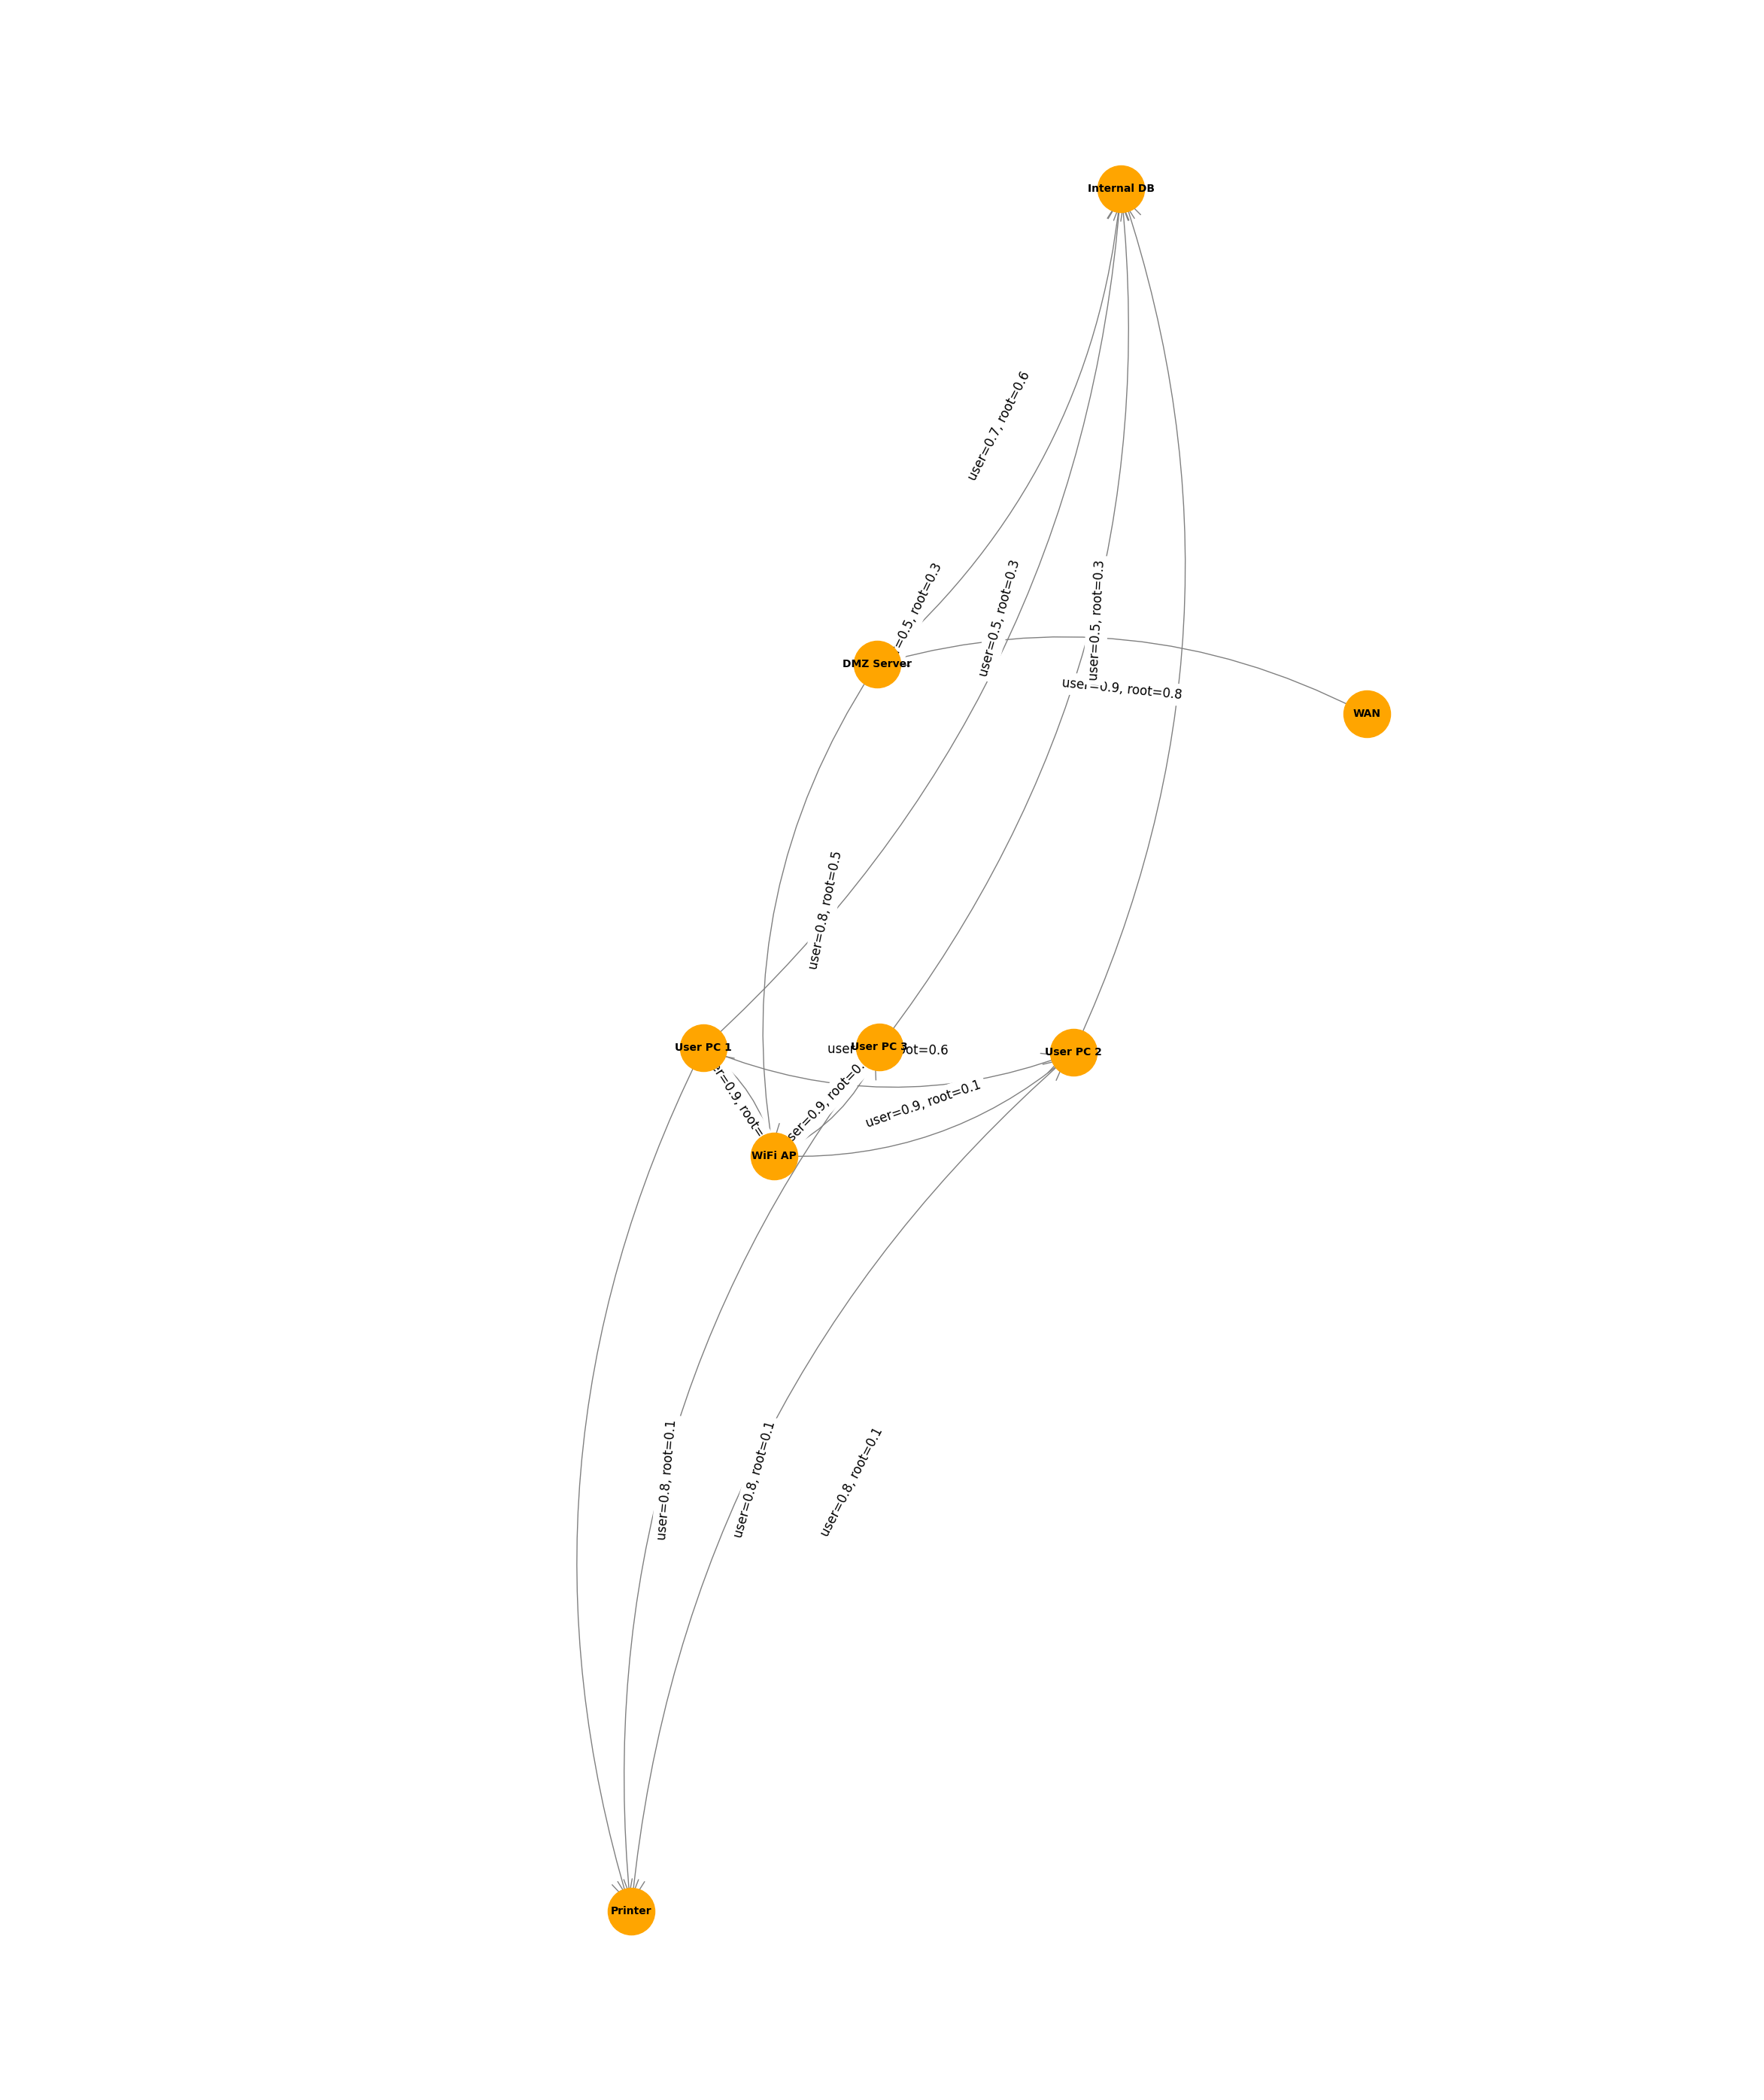

In [10]:
# --- Trực quan hóa đồ thị gốc (từ cell cũ) ---
plt.figure(figsize=(30, 36))
pos = nx.spring_layout(G_original) # Dùng G_original

nx.draw_networkx_nodes(G_original, pos, node_color='orange', node_size=2000)
nx.draw_networkx_labels(G_original, pos, font_size=10, font_weight='bold')

nx.draw_networkx_edges(
    G_original, pos,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=50,
    connectionstyle='arc3,rad=0.2'
)

# Vẽ nhãn trên cạnh
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G_original.edges(data=True)}
nx.draw_networkx_edge_labels(G_original, pos, edge_labels=edge_labels, font_size=12)

plt.axis('off')
plt.show()